Instalamos y actualizamos fastai para luego importar los modulos necesarios

In [1]:
!pip install -Uqq fastai
!pip install -Uqq fastbook

from fastbook import *
from fastai import *
from fastai.vision.widgets import *
import os

Definimos la API key para la busqueda de imagens por bing

In [2]:
# key = os.environ.get('AZURE_SEARCH_KEY', '')
# Generar una clave en https://azure.microsoft.com/es-es/services/cognitive-services/bing-web-search-api/
key = os.environ.get('AZURE_SEARCH_KEY', '')

Buscamos imagenes usando la API Key

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [4]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

Descargamos una imagen de prueba para revisar que sea correcta

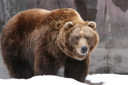

In [5]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128, 128)

Descargamos las imagenes que nos devolvio la búsqueda

In [6]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [7]:
if not path.exists():
  path.mkdir()
  for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls = results.attrgot('contentUrl'))

In [8]:
fns = get_image_files(path)
fns

(#434) [Path('bears/teddy/1d19117b-bb7e-4368-99ab-e41f1fcc7b23.jpg'),Path('bears/teddy/0f98c8a2-510c-4414-8d33-9b152842b729.jpg'),Path('bears/teddy/ffdf4f2b-4d8f-4391-9f86-6d61470b06ef.jpg'),Path('bears/teddy/efc63c86-f5c5-4c27-94e7-66a605cbda75.JPG'),Path('bears/teddy/2ef5ecf5-4447-4ca3-b91f-43b4adc7875c.jpg'),Path('bears/teddy/a0ad081e-7f80-470f-99a0-7787c6a59a1f.jpg'),Path('bears/teddy/ce014236-d6c4-4578-b2ab-57d208199ec0.jpeg'),Path('bears/teddy/c3b22405-aa49-4535-8d2b-b24c4a00ba0c.jpg'),Path('bears/teddy/39ac2691-88f1-4ae0-bdd6-6e453716b2f8.jpg'),Path('bears/teddy/bef9e3a9-8525-4b9a-b87e-545c0e86688f.jpg')...]

Verificar archivos descargados

In [9]:
failed = verify_images(fns)
failed

(#17) [Path('bears/teddy/efc63c86-f5c5-4c27-94e7-66a605cbda75.JPG'),Path('bears/teddy/605f8d0d-03bd-44d3-aa12-7911aafa9212.JPG'),Path('bears/teddy/83896763-21de-4f32-a1ea-175d8bd9c18d.jpg'),Path('bears/teddy/1108da8e-fd1b-474b-97a0-b8547c5665a3.jpg'),Path('bears/teddy/a9a4f837-17d3-4d0f-bf99-37b5183d92b4.JPG'),Path('bears/teddy/0e92c48a-0d43-438d-8f9d-b10756b51086.JPG'),Path('bears/teddy/07153b9c-18da-4fd0-919f-f7a9fff6c993.JPG'),Path('bears/teddy/0ff1fde3-a738-4200-bf84-4506f5f91521.jpg'),Path('bears/teddy/b5906abe-80d9-4f00-8efb-f70ee04cc018.png'),Path('bears/black/3bb16037-8f78-4477-8943-efb82e964ad7.jpg')...]

In [10]:
failed.map(Path.unlink)

(#17) [None,None,None,None,None,None,None,None,None,None...]

Creamos un DataLoader

In [11]:
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter( valid_pct = 0.2, seed = 42 ),
    get_y = parent_label,
    item_tfms = Resize(128)
)

In [12]:
dls = bears.dataloaders(path)

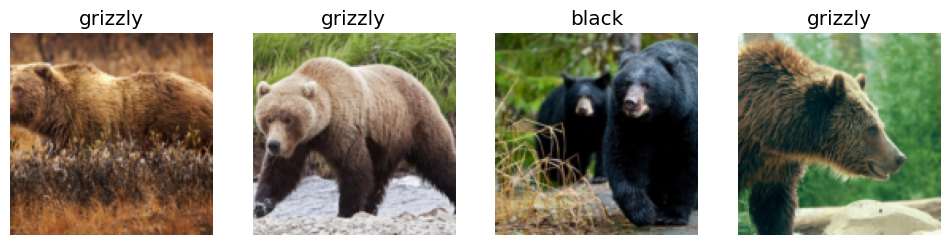

In [13]:
dls.valid.show_batch(max_n = 4, nrows = 1)

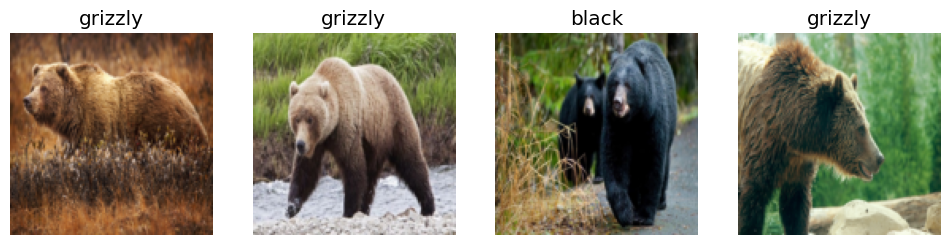

In [14]:
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

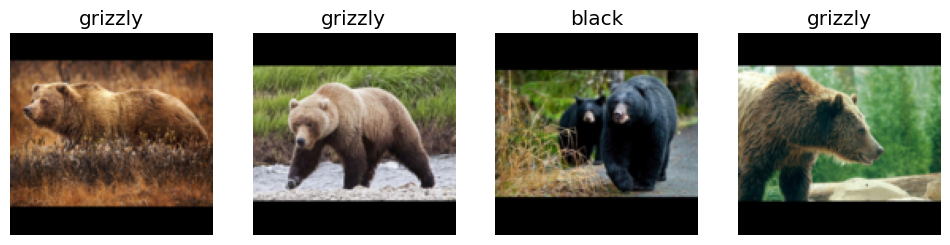

In [15]:
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

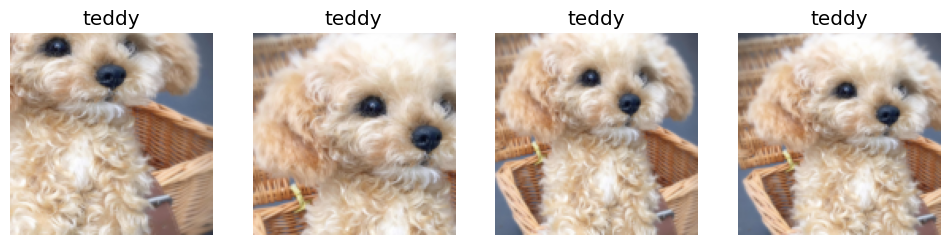

In [16]:
bears = bears.new( item_tfms = RandomResizedCrop(128, min_scale = 0.3))
dls = bears.dataloaders(path)
dls.train.show_batch( max_n = 4, nrows = 1, unique = True)

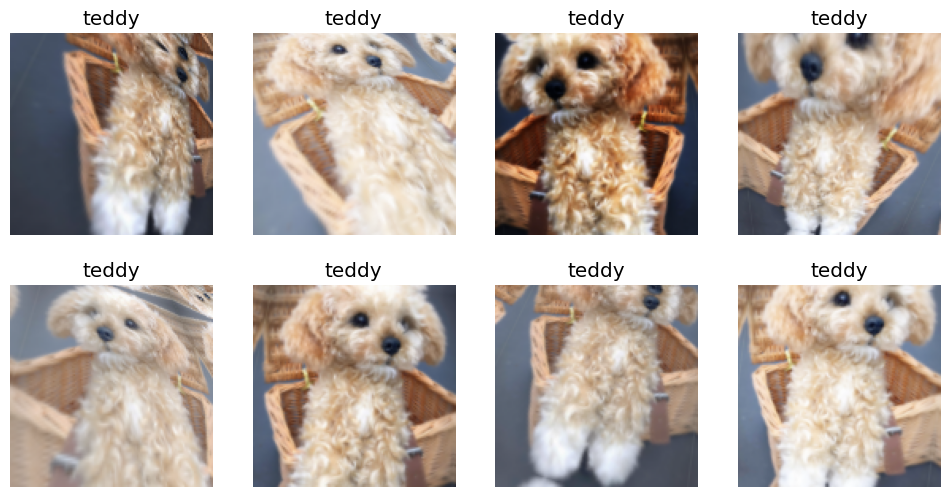

In [17]:
bears = bears.new(item_tfms = Resize(128), batch_tfms = aug_transforms ( mult = 2 ) )
dls = bears.dataloaders(path)
dls.train.show_batch( max_n = 8, nrows = 2, unique = True)

Entrenamiento del modelo y limpieza de los datos

In [18]:
bears = bears.new(
    item_tfms = RandomResizedCrop( 224, min_scale = 0.5 ),
    batch_tfms = aug_transforms()
)
dls = bears.dataloaders(path)

Creación de "learner" y fine tuning del modelo

In [19]:
learn = vision_learner( dls, resnet18, metrics = error_rate )
learn.fine_tune(6)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.8MB/s]


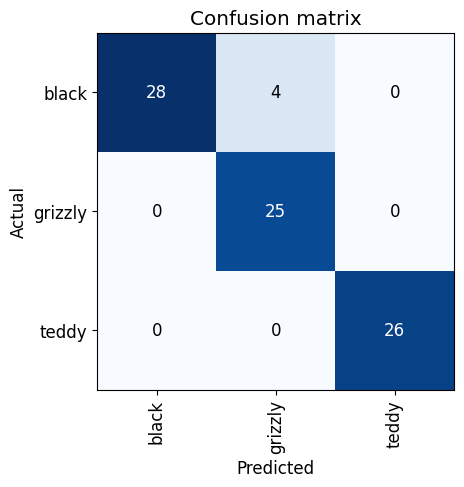

In [20]:
interp = ClassificationInterpretation.from_learner( learn )
interp.plot_confusion_matrix()

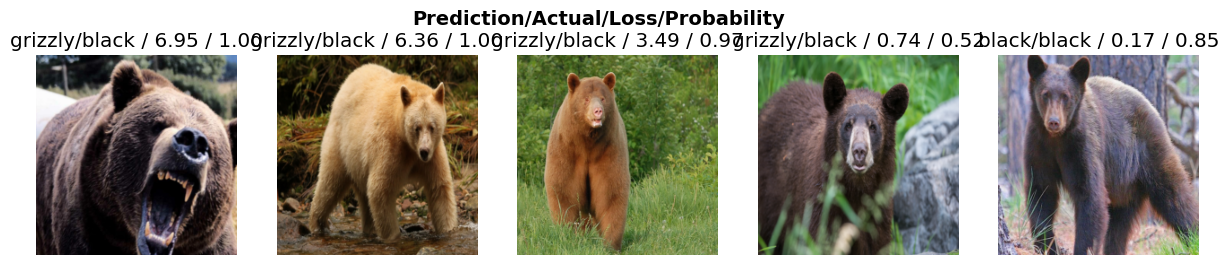

In [21]:
interp.plot_top_losses( 5, nrows = 1 )

Limpiaremos los resultados usando herramientas de FastAI

In [22]:
cleaner = ImageClassifierCleaner( learn )
cleaner

Borraremos y moveremos los elementos que hemos reclasificado a mano con las siguientes lineas

In [23]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move( str( cleaner.fns[idx]), path/cat)

Ahora exportaremos el modelo para producción

In [24]:
learn.export()

Verificamos que el archivo exista usando el método "ls"

In [25]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Ahora cargaremos el modelo ya entrenado y exportado para usarlo en una clasificación

In [26]:
learn_inf = load_learner( path/'export.pkl')

In [27]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([4.1874e-04, 9.9958e-01, 2.7334e-06]))

In [28]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [29]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [38]:
img = PILImage.create(btn_upload.data[-1])

In [39]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [40]:
pred, pred_idx, probs = learn_inf.predict(img)

In [41]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.8850')

In [42]:
btn_run = widgets.Button(description = 'Classify' )
btn_run

Button(description='Classify', style=ButtonStyle())

In [43]:
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,probs = learn_inf.predict(img)
  lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [44]:
btn_upload = widgets.FileUpload()

In [45]:
VBox([widgets.Label('Select your bear'),
      btn_upload, btn_run, out_pl, lbl_pred])